## Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchmetrics import Accuracy

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from kan import *
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


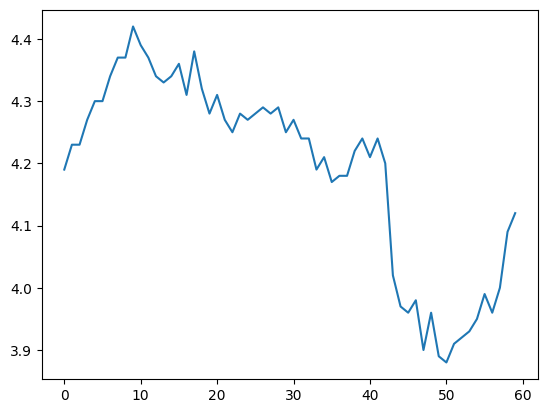

In [6]:
def treasury_data_retrieval():
    df = pd.read_csv('../data/us_treasury_rates.csv')
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values(by='Date', ascending=False, inplace=True)

    return df

id_list = range(10, 15)
df = treasury_data_retrieval()
# header = [1/12, 2/12, 3/12, 6/12, 1, 2, 3, 5, 7, 10, 20, 30]

# plt.figure(figsize=(16, 4))
# for id in range(10, 15):
#     row = df.iloc[id, 1:].values
#     plt.plot(header, row, marker='o')
# plt.legend(id_list)

plt.plot(df.iloc[:60, 5])

In [8]:
df.iloc[:, 1]

0      4.57
1      4.59
2      4.65
3      4.66
4      4.75
       ... 
728    0.05
729    0.04
730    0.05
731    0.06
732    0.05
Name: 1 Mo, Length: 733, dtype: float64

## Flatten data

In [116]:
n = len(df)
h = 3

flatten = pd.DataFrame()
for id in range(1, n):
    row = df.iloc[id:(id+h), 1:].stack().reset_index(drop=True).to_frame().T
    flatten = pd.concat([flatten, row], ignore_index=True)
flatten['y'] = df.iloc[:(n-1), 1]
flatten.dropna(inplace=True)
flatten.columns = flatten.columns.astype(str)

flatten.head()

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,y
0,4.59,4.53,4.46,4.46,4.38,4.23,4.15,4.10,4.07,4.12,...,4.40,4.27,4.17,4.13,4.11,4.17,4.23,4.50,4.40,4.57
1,4.65,4.54,4.47,4.46,4.38,4.23,4.13,4.09,4.07,4.13,...,4.43,4.30,4.17,4.11,4.08,4.13,4.19,4.46,4.36,4.59
2,4.66,4.56,4.49,4.48,4.40,4.27,4.17,4.13,4.11,4.17,...,4.42,4.30,4.13,4.10,4.05,4.10,4.18,4.45,4.36,4.65
3,4.75,4.63,4.51,4.51,4.43,4.30,4.17,4.11,4.08,4.13,...,4.43,4.34,4.19,4.17,4.11,4.17,4.25,4.52,4.44,4.66
4,4.76,4.69,4.58,4.52,4.42,4.30,4.13,4.10,4.05,4.10,...,4.45,4.37,4.21,4.21,4.17,4.24,4.30,4.56,4.48,4.75


## Trial models

In [117]:
def train_mse():
    predictions = model(dataset['train_input']).squeeze()  # Model predictions
    mse = F.mse_loss(predictions, dataset['train_label'], reduction='mean')  # Compute MSE
    return mse  # Return scalar MSE value

def test_mse():
    predictions = model(dataset['test_input']).squeeze()  # Model predictions
    mse = F.mse_loss(predictions, dataset['test_label'], reduction='mean')  # Compute MSE
    return mse

In [137]:
from sklearn.model_selection import KFold
import numpy as np

# Initialize the 5-fold cross-validator
kf = KFold(n_splits=5, shuffle=True, random_state=40)

# Store results for each fold
fold_results = {'train_mse': [], 'test_mse': []}

# Prepare data
X, y = flatten.drop(columns='y'), flatten['y']
n = X.shape[1]

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"Fold {fold + 1}")
    
    # Split data into train and test for the current fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    # Prepare dataset for the current fold
    dataset = dict()
    dtype = torch.get_default_dtype()
    dataset['train_input'] = torch.from_numpy(X_train.values).type(dtype).to(device)
    dataset['train_label'] = torch.from_numpy(y_train.values).type(dtype).to(device)
    dataset['test_input'] = torch.from_numpy(X_test.values).type(dtype).to(device)
    dataset['test_label'] = torch.from_numpy(y_test.values).type(dtype).to(device)
    
    # Initialize the model
    model = KAN(width=[n, 6, 1], grid=3, k=2, seed=42, device=device)
    
    # Train the model and compute metrics
    results = model.fit(dataset, opt="Adam", lamb=0.0, lr=0.001, steps=100, metrics=(train_mse, test_mse))

    # model.prune()
    # results = model.fit(dataset, opt="Adam", lamb=0.0, lr=0.001, steps=10, metrics=(train_mse, test_mse))
    
    # Store the metrics
    fold_results['train_mse'].append(results['train_mse'][-1])
    fold_results['test_mse'].append(results['test_mse'][-1])

# Calculate average metrics across all folds
avg_train_mse = np.mean(fold_results['train_mse'])
avg_test_mse = np.mean(fold_results['test_mse'])

print("5-Fold Cross-Validation Results")
print(f"Average Train MSE: {avg_train_mse}")
print(f"Average Test MSE: {avg_test_mse}")


Fold 1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.13e+00 | test_loss: 4.98e+00 | reg: 0.00e+00 | :   0%|      | 0/100 [00:00<?, ?it/s]

| train_loss: 6.60e-01 | test_loss: 6.20e-01 | reg: 2.98e+01 | : 100%|█| 100/100 [00:01<00:00, 51.07


saving model version 0.1
Fold 2
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.52e-01 | test_loss: 6.73e-01 | reg: 2.93e+01 | : 100%|█| 100/100 [00:01<00:00, 51.42


saving model version 0.1
Fold 3
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.63e-01 | test_loss: 6.33e-01 | reg: 2.93e+01 | : 100%|█| 100/100 [00:01<00:00, 50.02


saving model version 0.1
Fold 4
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.57e-01 | test_loss: 6.54e-01 | reg: 2.94e+01 | : 100%|█| 100/100 [00:01<00:00, 50.41


saving model version 0.1
Fold 5
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.51e-01 | test_loss: 6.93e-01 | reg: 2.92e+01 | : 100%|█| 100/100 [00:01<00:00, 51.01

saving model version 0.1
5-Fold Cross-Validation Results
Average Train MSE: 0.13648248871649277
Average Test MSE: 0.13629493549733138


In [133]:
from sklearn.metrics import mean_squared_error 

y_pred = model(dataset['test_input']).cpu().detach().numpy().flatten()
y_test = dataset['test_label'].cpu().detach().numpy().flatten()

mean_squared_error(y_pred, y_test)

np.float64(0.36517424898232753)

In [134]:
pd.DataFrame({
    'pred': y_pred,
    'real': y_test}).head()

,pred,real
0,5.141209,4.59
1,5.134779,4.74
2,5.145110,4.74
3,5.166321,4.75
4,5.156951,4.88


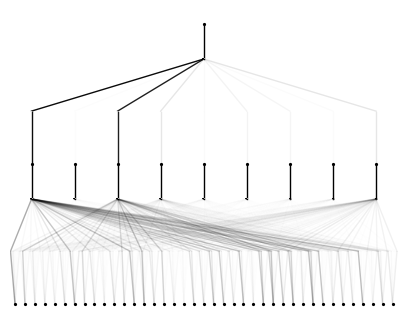

In [78]:
model.plot()